In [ ]:
from google.colab import drive
drive.mount('drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [ ]:
%cd '/content/drive/My Drive/DL'
!ls

/content/drive/My Drive/DL
wheat.csv  wheat_detection


In [ ]:
# %env CUDA_LAUNCH_BLOCKING=1

In [ ]:
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import math
import copy

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensor

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = 'wheat_detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [ ]:
# train_df = pd.read_csv(f'{DIR_INPUT}/wheat_train.csv')
# valid_df = pd.read_csv(f'{DIR_INPUT}/wheat_test.csv')

# size_reduce_factor = 0.1

# image_ids = train_df['image_id'].unique()
# image_ids = image_ids[0:round(len(image_ids)*size_reduce_factor)]
# train_df = train_df[train_df['image_id'].isin(image_ids)]

# image_ids = valid_df['image_id'].unique()
# image_ids = image_ids[0:round(len(image_ids)*0.5)]
# valid_df = valid_df[valid_df['image_id'].isin(image_ids)]

# train_df.describe()

validation_fold = 0

input_df = pd.read_csv(f'{DIR_INPUT}/wheat_1024.csv')
valid_df = input_df[input_df['fold']==validation_fold]
train_df = input_df[input_df['fold']!=validation_fold]

# size_reduce_factor = 0.05

# image_ids = train_df['image_id'].unique()
# image_ids = image_ids[0:round(len(image_ids)*size_reduce_factor)]
# train_df = train_df[train_df['image_id'].isin(image_ids)]

# image_ids = valid_df['image_id'].unique()
# image_ids = image_ids[0:round(len(image_ids)*0.5)]
# valid_df = valid_df[valid_df['image_id'].isin(image_ids)]

train_df.head()

,image_id,x_min,y_min,x_max,y_max,class_name,fold
0,b6ab77fd7.jpg,834.0,222.0,890.0,258.0,head,3
1,b6ab77fd7.jpg,226.0,548.0,356.0,606.0,head,3
2,b6ab77fd7.jpg,377.0,504.0,451.0,664.0,head,3
3,b6ab77fd7.jpg,834.0,95.0,943.0,202.0,head,3
4,b6ab77fd7.jpg,26.0,144.0,150.0,261.0,head,3


In [ ]:
disp_examples = False

if disp_examples:

  image_id = train_df['image_id'].iloc[1000]
  records = train_df[train_df['image_id']==image_id]
  boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
  # fig, ax = plt.subplots(15, 1, figsize=(160, 80))
  img = cv2.imread(f'{DIR_TRAIN}/{image_id}', cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#convert to rgb

  # img2 = img.copy()
  # augment_hsv(img2, hgain=0.2, sgain=0, vgain=0)

  # img = cv2.flip(img,1)


  for box in boxes:
    # box = boxes[idx_box:]
    # x_min = 1024-box[0]
    img = cv2.rectangle(img,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  (255,0,0),  2)
  # ax[0].imshow(img)
  plt.figure(figsize=(8,8))
  plt.imshow(img.astype(np.int))

  # plt.figure(figsize=(8,8))
  # plt.imshow(img2.astype(np.int))

In [ ]:
# bin_width = 10
# bins = np.arange(0,256,bin_width)
# # hue_dist = np.zeros((bins.shape[0]-1,))
# hue_dist = list()
# value_dist = list()
# sat_dist = list()
# N_image = 0

# for image_id in train_df['image_id'].unique():
  
#   img = cv2.imread(f'{DIR_TRAIN}/{image_id}', cv2.IMREAD_COLOR)
#   hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))

#   # hst_hue,_ = np.histogram(hue,bins)
#   # hue_dist += hst_hue
#   # hue_dist.append(np.argmax(hst_hue))

#   # hst_sat,_ = np.histogram(hue,bins)
#   # sat_dist.append(np.argmax(hst_sat))

#   # hst_value,_ = np.histogram(hue,bins)
#   # value_dist.append(np.argmax(hst_value))

#   hue_dist.append(np.median(hue.flatten()))
#   value_dist.append(np.median(sat.flatten()))
#   sat_dist.append(np.median(val.flatten()))

#   N_image += 1

#   if (N_image%100==0):
#     print(f"{N_image} images processed")


In [ ]:
# plt.bar(bins[:-1]+bin_width/2,hue_dist, width=10)
#plt.hist(hue_dist,bins)

In [ ]:
from sklearn.utils import shuffle
import random
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.df = dataframe
        self.image_ids = dataframe['image_id'].unique()
        # self.image_ids = shuffle(self.image_ids)
        self.labels = [np.zeros((0, 5), dtype=np.float32)] * len(self.image_ids)
        self.img_size = 1024
        im_w = 1024
        im_h = 1024
        for i, img_id in enumerate(self.image_ids):
            records = self.df[self.df['image_id'] == img_id]
            boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
            # boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            # boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
            boxesyolo = []
            for box in boxes:
                x1, y1, x2, y2 = box
                xc, yc, w, h = 0.5*x1/im_w+0.5*x2/im_w, 0.5*y1/im_h+0.5*y2/im_h, abs(x2/im_w-x1/im_w), abs(y2/im_h-y1/im_h)
                boxesyolo.append([0, xc, yc, w, h])
            self.labels[i] = np.array(boxesyolo)
        
        self.image_dir = image_dir
        self.transforms = transforms
        
        self.augment = True
        self.augment_colorspace = True
        self.minimum_boxes_to_augment = 10

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        x = self.labels[index]

        self.hflip = False
        self.vflip = False
        self.mosaic = False

        if self.augment and len(x)>=self.minimum_boxes_to_augment:

            if random.randint(0,1) == 0:
              self.hflip = True

            if random.randint(0,1) == 0:
              self.vflip = True

            if random.randint(0,1) == 0:
              self.mosaic = True

        if self.mosaic:
                # Load mosaic
                img, labels = load_mosaic(self, index)
                shapes = None

        else:
                # Load image
                img, (h0, w0), (h, w) = load_image(self, index)

                # Letterbox
                shape = self.img_size  # final letterboxed shape
                img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
                shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling

                if x.size > 0:

                    img, x = do_flips(self, img, x)

                    # Normalized xywh to pixel xyxy format
                    labels = x.copy()
                    labels[:, 1] = ratio[0] * w * (x[:, 1] - x[:, 3] / 2) + pad[0]  # pad width
                    labels[:, 2] = ratio[1] * h * (x[:, 2] - x[:, 4] / 2) + pad[1]  # pad height
                    labels[:, 3] = ratio[0] * w * (x[:, 1] + x[:, 3] / 2) + pad[0]
                    labels[:, 4] = ratio[1] * h * (x[:, 2] + x[:, 4] / 2) + pad[1]
        
                if self.augment and len(x)>=self.minimum_boxes_to_augment:
                    # img, labels = random_affine(img, labels,
                    #                degrees= 15.,
                    #                translate=0.,
                    #                scale=0.2,
                    #                shear=0) 
                    
                    img, labels = random_affine(img, labels, #version 2
                                   degrees= 0.,
                                   translate=0.,
                                   scale=0.,
                                   shear=0) 
                    
                    
        if self.augment_colorspace:
            # Augment colorspace
            # augment_hsv(img, hgain=1, sgain=0.3, vgain=0.3)#full
            # augment_hsv(img, hgain=0.5, sgain=0.3, vgain=0.3)
            augment_hsv(img, hgain=0.0, sgain=0.1, vgain=0.1) #version 2

        target = {}

        class_labels = torch.ones((labels.shape[0],), dtype=torch.int64)
        
        target['boxes'] = labels[:,1:]
        target['labels'] = class_labels
        target['image_id'] = torch.tensor([index])


        if self.transforms:
            sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': class_labels
            }
            sample = self.transforms(**sample)
            img = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(lambda x:torch.tensor(x, dtype=torch.float32), zip(*sample['bboxes'])))).permute(1, 0)

        return img, target, image_id


        # return img, labels

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def load_image(self, index):
    # loads 1 image from dataset, returns img, original hw, resized hw
    image_id = self.image_ids[index]
    imgpath = f'{DIR_TRAIN}'
    img = cv2.imread(f'{imgpath}/{image_id}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#convert to rgb

    assert img is not None, 'Image Not Found ' + imgpath
    h0, w0 = img.shape[:2]  # orig hw
    return img, (h0, w0), img.shape[:2]  # img, hw_original, hw_resized

In [ ]:
def do_flips(self, img, labels_in):

  labels = labels_in.copy()
  
  if self.hflip:
      img = cv2.flip(img, 1)
      labels[:, 1] = 1. - labels[:, 1]
  if self.vflip:
      img = cv2.flip(img, 0)
      labels[:, 2] = 1. - labels[:, 2]


  return img, labels

In [ ]:
def load_mosaic(self, index):
    # loads images in a mosaic

    labels4 = []
    s = self.img_size
    xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
    indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]  # 3 additional image indices
    for i, index in enumerate(indices):
        # Load image
        img, _, (h, w) = load_image(self, index)

        x = self.labels[index]

        img, x = do_flips(self, img, x)

        labels = x.copy()

        # place img in img4
        if i == 0:  # top left
            img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a - x1b
        padh = y1a - y1b


        if x.size > 0:  # Normalized xywh to pixel xyxy format
            labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
            labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
            labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
            labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
        labels4.append(labels)

    # Concat/clip labels
    if len(labels4):
        labels4 = np.concatenate(labels4, 0)
        # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
        np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine

    # Augment
    # img4 = img4[s // 2: int(s * 1.5), s // 2:int(s * 1.5)]  # center crop (WARNING, requires box pruning)
    img4, labels4 = random_affine(img4, labels4,
                                   degrees=0.,
                                   translate=0.,
                                   scale=0.,
                                   shear=0,
                                   border=-s // 2)  # border to remove
    
    return img4, labels4

In [ ]:
def random_affine(img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, border=0):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4

    if targets is None:  # targets = [cls, xyxy]
        targets = []
    height = img.shape[0] + border * 2
    width = img.shape[1] + border * 2

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  # x translation (pixels)
    T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  # y translation (pixels)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Combined rotation matrix
    M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
    if (border != 0) or (M != np.eye(3)).any():  # image changed
        img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, borderValue=(np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255)))
    

    # Transform label coordinates
    n = len(targets)
    if n:
        # warp points
        xy = np.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = (xy @ M.T)[:, :2].reshape(n, 8)

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

        # # apply angle-based reduction of bounding boxes
        # radians = a * math.pi / 180
        # reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
        # x = (xy[:, 2] + xy[:, 0]) / 2
        # y = (xy[:, 3] + xy[:, 1]) / 2
        # w = (xy[:, 2] - xy[:, 0]) * reduction
        # h = (xy[:, 3] - xy[:, 1]) * reduction
        # xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

        # reject warped points outside of image
        xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
        xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
        w = xy[:, 2] - xy[:, 0]
        h = xy[:, 3] - xy[:, 1]
        area = w * h
        area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
        ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
        i = (w > 4) & (h > 4) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 10)

        targets = targets[i]
        targets[:, 1:5] = xy[i]

    return img, targets


In [ ]:
def augment_hsv(img, hgain=0.5, sgain=0.5, vgain=0.5):
    r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains +-hgain, +-sgain, +-vgain
    hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
    dtype = img.dtype  # uint8

    x = np.arange(0, 256, dtype=np.int16)
    lut_hue = ((x * r[0]) % 180).astype(dtype) #opencv codes hue btw 0 and 179 deg
    lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
    lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

    img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
    cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB, dst=img)  # no return needed #back to rgb

In [ ]:
def letterbox(img, new_shape=(416, 416), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 64), np.mod(dh, 64)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = new_shape
        ratio = new_shape[0] / shape[1], new_shape[1] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [ ]:
def get_train_transform():
    return A.Compose([
        # A.Flip(0.5),
        ToTensor()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensor()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())

valid_dataset.augment = False
valid_dataset.augment_colorspace = False

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)


In [ ]:
# torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
train_dataset.augment = True
train_dataset.augment_colorspace = True

disp_examples = False

if disp_examples:
  images, targets, image_ids = next(iter(train_data_loader))
  # images, targets, image_ids = next(iter(valid_data_loader))
  images = list(image.to(device) for image in images)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
if disp_examples:
  
  imindex = random.randint(0,len(images)-1)

  boxes = targets[imindex]['boxes'].cpu().numpy().astype(np.int32)
  sample = images[imindex].permute(1,2,0).cpu().numpy().astype(np.float32)

  # imindex = random.randint(0,len(train_dataset)-1)

  # boxes = train_dataset[imindex][1]['boxes'].numpy().astype(np.int32)
  # sample = train_dataset[imindex][0].permute(1,2,0).numpy().astype(np.float32)

  fig, ax = plt.subplots(1, 1, figsize=(16, 8))

  for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (1, 0, 0), 3)
    
  ax.set_axis_off()
  ax.imshow(sample)

In [ ]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)
 
def get_metric_image(gt_boxes, pred_boxes, conf, iou_thr):

  N_pred_boxes = len(pred_boxes)
  N_gt_boxes = len(gt_boxes)
  M = np.zeros((N_pred_boxes, N_gt_boxes), dtype = bool)

  pred_boxes = list(zip(pred_boxes, conf))
  sorted(pred_boxes, key=lambda x:x[1])

  for idx_gt_box in range(N_gt_boxes):
    better_pred_box_found = 0
    for idx_pred_box in range(N_pred_boxes):
      res = (iou(pred_boxes[idx_pred_box][0], gt_boxes[idx_gt_box])>iou_thr)
      M[idx_pred_box, idx_gt_box] = (res &   ~better_pred_box_found)
      if res:
        better_pred_box_found = 1

  FN = sum(M.sum(0)==0) #ground truth object had no associated predicted object.
  FP = sum(M.sum(1)==0) #predicted object had no associated ground truth object
  TP = N_pred_boxes-FP

  # print('TP:{} FP:{} FN:{}\n'.format(TP,FP,FN))
  return TP,FP,FN

In [ ]:
%matplotlib inline
import time
import pylab as pl
from IPython import display


def disp_progress(hist, epoch):

     display.clear_output(wait=True)

     if isinstance(hist['train_loss'][0],float):
       train_loss = hist['train_loss']
     else:
       train_loss = list(zip(*hist['train_loss']))[-1]

     val_metric = list(zip(*hist['val_metric']))[0]
     train_metric = list(zip(*hist['train_metric']))[0]

     plt.figure(1)
     plt.clf()
     plt.plot(train_metric, 'r-', lw=2, label='train', Marker = '.', MarkerSize = 20)
     plt.plot(val_metric, 'b-', lw=2, label='val', Marker = '.', MarkerSize = 20)
     plt.legend()
     plt.grid()
     plt.ylabel('Metrics', fontsize=15)
     plt.xlabel('epoch', fontsize=15)
     display.display(plt.gcf())
     plt.close()

     plt.figure(2)
     plt.clf()
     plt.plot(train_loss, 'r-', lw=1, Marker = '.', MarkerSize = 20)
     plt.grid()
     plt.ylabel('Training loss', fontsize=15)
     plt.xlabel('epoch', fontsize=15)
     display.display(plt.gcf())
     plt.close()




In [ ]:
from tqdm.notebook import tqdm
import time

def train(model):

  beta = 0.98

  train_itr = 1

  model.train()

  # loss_hist = list()

  # N_images = 0
  
  avg_loss = 0.

  pbar = tqdm(total = math.ceil(len(train_dataset)/train_data_loader.batch_size))

  for images, targets, _ in train_data_loader:
       

      images = list(image.to(device)for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      #Triangular sheduler 
      if isinstance(lr_scheduler, TriangularSchedule):

          optimizer.param_groups[0]['lr'] = lr_scheduler.lr
          optimizer.param_groups[0]['momentum'] = lr_scheduler.momentum

      loss_dict = model(images, targets)

      losses = sum(loss for loss in loss_dict.values())

      # loss_hist.append([x.item() for y,x in loss_dict.items()])
      
      # N_images += len(images)
    
      # train_loss = np.sum(list(zip(*loss_hist)),1)/(N_images)
      # train_loss = np.append(train_loss, np.sum(train_loss))

      train_itr += 1

      avg_loss = beta * avg_loss + (1-beta)*losses.item()/len(images)
      smoothed_loss = avg_loss / (1 - beta**train_itr) 
        
      # if train_itr % 10 == 0:
      #     print(f"Iteration #{train_itr} loss: {train_loss[-1]}")

      pbar.update(1)
      pbar.set_description(f"Running loss:{smoothed_loss:.8f}")

      # del images
      # if train_itr < 5:
      #     time.sleep(10)

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      if isinstance(lr_scheduler, TriangularSchedule):
        lr_scheduler.step()

  del pbar

  return smoothed_loss

def validate(model, data_loader, max_itr, iou_thr=0.5, detection_thr = 0.):

  model.eval()

  val_metric = 0.
  FP_tot = 0.
  TP_tot = 0.
  FN_tot = 0.

  val_itr = 0

  N_images = 0

  pbar = tqdm(total = max_itr)

  with torch.no_grad():

    for images, targets, _ in data_loader:

      images = list(image.to(device) for image in images)

      outputs = model(images)

      for idx_image in range(len(images)):

          pred_boxes =  outputs[idx_image]['boxes'].cpu().numpy()
          conf = outputs[idx_image]['scores'].cpu().numpy()

          gt_boxes = targets[idx_image]['boxes'].numpy()

          pred_boxes = pred_boxes[conf >= detection_thr]
          conf = conf[conf >= detection_thr]

          TP,FP,FN = get_metric_image(gt_boxes, pred_boxes, conf, iou_thr)

          TP_tot += TP
          FP_tot += FP
          FN_tot += FN

          val_metric += TP/float(TP+FP+FN)

      val_itr += 1

      N_images += len(images)

      pbar.update(1)
      pbar.set_description(f"Metric: {val_metric/N_images:.3f}")

      if val_itr == max_itr:
        break

  del pbar

  return val_metric/N_images, TP_tot/N_images, FP_tot/N_images, FN_tot/N_images

In [ ]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, rpn_nms_thresh = 0.83)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, rpn_nms_thresh = 0.83)

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
def find_lr(init_value = 1e-8, final_value = 10., weight_decay = 0.0, num = None, beta = 0.9):

    if num == None:
      num = len(train_dataset)//float(train_data_loader.batch_size)

    mult = (final_value / init_value) ** (1/num)
    lr = init_value

    optimizer.param_groups[0]['lr'] = lr
    optimizer.param_groups[0]['weight_decay'] = weight_decay

    # optimizer = torch.optim.Adam(params, lr=lr)
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []

    pbar = tqdm(total = num)

    model.train()

    for data in train_data_loader:

        batch_num += 1

        #As before, get the loss for this mini-batch of inputs/outputs
        images,targets,_ = data
        images = list(image.to(device)for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)

        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses

        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss

        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))

        #Do the SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.update(1)
        pbar.set_description(f"LR: {lr:e} Loss: {smoothed_loss:.5f}")

        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
        # optimizer = torch.optim.Adam(params, lr=lr)

        if batch_num>=num:
          break

    del pbar 

    return log_lrs, losses

In [ ]:
#get LR plot for several weight decays
# log_lrs = []
# losses = []
# optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9)#, weight_decay=0.0005)

# total_iter = len(train_dataset)//float(train_data_loader.batch_size)//2

# for wd in [0, 1e-5, 1e-4, 1e-3]:
#   print(f'Computing learning rates for weight decay:{wd:g}')
#   model.load_state_dict(torch.load('/content/drive/My Drive/DL/wheat_detection/models/NMS_04_state0'))
#   log_lrs_, losses_ = find_lr(1e-8, 10, wd, total_iter)
#   log_lrs.append(log_lrs_)
#   losses.append(losses_)



# plt.plot(log_lrs[0], losses[0], 'r--', log_lrs[1], losses[1], 'b.-', log_lrs[2], losses[2], 'g^', log_lrs[3], losses[3], 'k')


In [ ]:
class TriangularSchedule():

      def __init__(self, epochs_per_cycle, batches_per_epoch,  min_LR, max_LR, iter = 0, min_momentum = 0.8, max_momentum = 0.95):

        self.cycle_length = batches_per_epoch*epochs_per_cycle

        self.min_LR = min_LR
        self.max_LR = max_LR
        self.min_momentum = min_momentum
        self.max_momentum = max_momentum
        self.lr_slope = (max_LR - min_LR)/(self.cycle_length//2)
        self.momentum_slope = (max_momentum - min_momentum)/(self.cycle_length//2)

        self.iter = iter
        self.step()

      def step(self):

        if self.iter <= self.cycle_length//2:

          self.lr = self.min_LR + self.iter * self.lr_slope #increase lr
          self.momentum = self.max_momentum - self.iter * self.momentum_slope #reduce momentum

        else:

          self.lr = self.max_LR - (self.iter - self.cycle_length//2) * self.lr_slope
          self.momentum = self.min_momentum + (self.iter - self.cycle_length//2) * self.momentum_slope

        self.iter += 1

        if self.iter >= self.cycle_length:
          self.iter = 0

      def reset(self):

        self.iter = 0
        self.step()

      def get_all(self):

        return {'lr':self.lr, 'momentum':self.momentum, 'iter':self.iter, 'min_lr':self.min_LR, 'max_lr':self.max_LR, 'min_momentum':self.min_momentum,
                'max_momentum': self.max_momentum, 'cycle_length':self.cycle_length}

In [ ]:
optimizer = torch.optim.SGD(params, lr=0.005)#, weight_decay=0.0005)
lr_scheduler = TriangularSchedule(epochs_per_cycle = 8, batches_per_epoch = math.ceil(len(train_dataset)/train_data_loader.batch_size),  min_LR = 2e-3, max_LR = 8e-3)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# optimizer = torch.optim.Adam(params, lr=2e-4)
# optimizer = torch.optim.Adam(params, lr=2e-4)
# optimizer = torch.optim.RMSprop(params, lr=1e-4)
# lr_scheduler = None

# model.load_state_dict(torch.load('/content/drive/My Drive/DL/wheat_detection/models/NMS_04_state0'))


In [ ]:
#check triangularscheduler

# lrates = []
# momenta = []
# for i_iter in range(math.ceil(len(train_dataset)/train_data_loader.batch_size)*8):
#   lrates.append(lr_scheduler.lr)
#   momenta.append(lr_scheduler.momentum)
#   lr_scheduler.step()

# print(f'LR scheduler parameters:\n')

# print(lr_scheduler.get_all())

# lr_scheduler.reset()

# print(f'LR scheduler parameters after reset:\n')

# print(lr_scheduler.get_all())

# # plt.plot(lrates)
# plt.plot(momenta)

In [ ]:
load_weights = True
if load_weights:
  import pickle
  model_file_base = '/content/drive/My Drive/DL/wheat_detection/models/SGD_NMS096_AUGM2x_1024_FOLD_0/24_07_epoch_38'
  model_file_base = '/content/drive/My Drive/DL/wheat_detection/models/SGD_NMS083_AUGM2x_1024_FOLD_0/25_07_epoch_8'

  model.load_state_dict(torch.load(model_file_base + '_weights'))
  # optimizer.load_state_dict(torch.load(model_file_base + '_optimizer'))
  model_meta = pickle.load(open(model_file_base+ '_hist','rb'))
  first_epoch = model_meta['epoch']+1
  hist = model_meta['hist']
  best_val_metric = hist['val_metric'][-1][0]
  if not 'lr_scheduler' in model_meta.keys():
    itr = first_epoch%8*math.ceil(len(train_dataset)/train_data_loader.batch_size)-1
    lr_scheduler = TriangularSchedule(epochs_per_cycle = 8, batches_per_epoch = math.ceil(len(train_dataset)/train_data_loader.batch_size),  min_LR = 2e-3, max_LR = 8e-3, iter=itr)
  else:
    lr_scheduler = model_meta['lr_scheduler']  


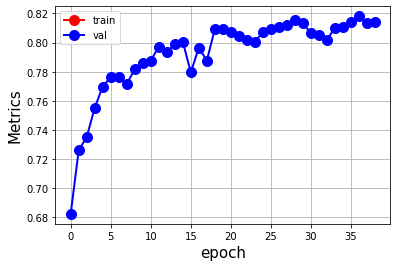

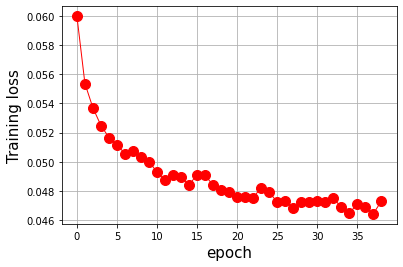

[0.8141352695519053, 39.28888888888889, 4.364444444444445, 4.038518518518519]

In [ ]:
# import pickle
# # model_file_base = '/content/drive/My Drive/DL/wheat_detection/models/SGD_NMS096_AUGM_2x_FOLD_0/17_07_epoch_28'
# model_file_base = '/content/drive/My Drive/DL/wheat_detection/models/SGD_FOLD_0/10_07_epoch_28'
# model_file_base = '/content/drive/My Drive/DL/wheat_detection/models/SGD_NMS096_FOLD_0/22_07_epoch_20'
# model_file_base = '/content/drive/My Drive/DL/wheat_detection/models/SGD_NMS096_AUGM2x_1024_FOLD_0/24_07_epoch_38'


# model_meta = pickle.load(open(model_file_base+ '_hist','rb'))
# disp_progress(model_meta['hist'],0)
# model_meta['hist']['val_metric'][-1]

In [ ]:
# max_itr_valid_metric = math.ceil(len(valid_dataset)/float(valid_data_loader.batch_size))
# val_metric, TP_val, FP_val, FN_val = validate(model, valid_data_loader, max_itr_valid_metric, detection_thr = 0.15)
# print(FP_val)
# print(FN_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


2.242962962962963
5.579259259259259


In [ ]:
import pickle
import copy
from datetime import datetime
import time
import os

base_models_dir = '/content/drive/My Drive/DL/wheat_detection/models/SGD_NMS083_AUGM2x_1024_FOLD_' + str(validation_fold) + '/'
if not os.path.exists(base_models_dir):
   os.mkdir(base_models_dir)

num_epochs = 44

if load_weights==False:
  best_val_metric = 0.0
  hist = {'train_loss':[], 'val_metric':[], 'train_metric':[]}
  first_epoch = 0

# first_epoch = 24

# max_itr_train_metric = math.ceil(len(valid_dataset)/float(train_data_loader.batch_size))
max_itr_valid_metric = math.ceil(len(valid_dataset)/float(valid_data_loader.batch_size))

for epoch in range(first_epoch, num_epochs+1):

    # if epoch <=8:
    #     train_dataset.augment = False
    #     train_dataset.augment_colorspace = False
    # else:
    #     train_dataset.augment = True
    #     train_dataset.augment_colorspace = True

    since = time.time()
    print(f"Training for epoch: {epoch}")
    train_loss = train(model)
    training_time = time.time() - since
    print('complete in {:.0f}m {:.0f}s'.format(
        training_time // 60, training_time % 60))

  #   print(f"EPOCH #{epoch}\n loss_box_reg: {train_loss[0]}\n loss_classifier: {train_loss[1]}\n\
  #  loss_objectness: {train_loss[2]}\n loss_rpn_box_reg: {train_loss[3]}\nTOTAL LOSS: {train_loss[4]}\n")
    print(f"EPOCH #{epoch}\n TOTAL LOSS: {train_loss}\n")

    since = time.time()
    print(f"Computing training metric")
    # train_metric, TP_train, FP_train, FN_train = validate(model, train_data_loader, max_itr_train_metric)
    train_metric, TP_train, FP_train, FN_train = np.nan, np.nan, np.nan, np.nan
    training_metric_time = time.time() - since
    print('complete in {:.0f}m {:.0f}s'.format(
        training_metric_time // 60, training_metric_time % 60))

    since = time.time()
    print(f"Computing validation metric")
    val_metric, TP_val, FP_val, FN_val = validate(model, valid_data_loader, max_itr_valid_metric)
    # val_metric, TP_val, FP_val, FN_val = np.nan, np.nan, np.nan, np.nan
    validation_metric_time = time.time() - since
    print('complete in {:.0f}m {:.0f}s'.format(
        validation_metric_time // 60, validation_metric_time % 60))

    hist['train_loss'].append(train_loss)
    hist['val_metric'].append([val_metric, TP_val, FP_val, FN_val])
    hist['train_metric'].append([train_metric, TP_train, FP_train, FN_train])

    time.sleep(2)

    disp_progress(hist, epoch)
  
  #   print(f"EPOCH #{epoch}\n loss_box_reg: {train_loss[0]}\n loss_classifier: {train_loss[1]}\n\
  #  loss_objectness: {train_loss[2]}\n loss_rpn_box_reg: {train_loss[3]}\nTOTAL LOSS: {train_loss[4]}\n")
    print(f"EPOCH #{epoch}\n TOTAL LOSS: {train_loss}\n")
    print(f"TRAIN METRIC:{train_metric} TP:{np.round(TP_train)} FP:{np.round(FP_train)} FN:{np.round(FN_train)}")  
    print(f"VALIDATION METRIC:{val_metric} TP:{np.round(TP_val)} FP:{np.round(FP_val)} FN:{np.round(FN_val)}\n")   
      
    if epoch%2==0:
    # if val_metric > best_val_metric or epoch==num_epochs-1:

        # print(f'BEST EVALUATION METRIC! OLD:{best_val_metric} NEW:{val_metric}')
        print(f'SAVING MODEL STATE\n')

        if val_metric > best_val_metric:
          best_val_metric = val_metric

        now = datetime.now()
        # file_name = base_models_dir + now.strftime("%d_%m")

        file_name = base_models_dir + now.strftime("%d_%m") + '_epoch_' + str(epoch)

        torch.save(model.state_dict(), file_name+"_weights")

        # torch.save(optimizer.state_dict(), file_name+"_optimizer")

        # date_time = now.strftime("%d_%m_%y_%H_%M_%S")
 
        model_meta = {'hist': hist,
                      'epoch': epoch,
                      'lr_scheduler': lr_scheduler}

        pickle.dump(model_meta, open(file_name+"_hist", 'wb'))



In [ ]:
epoch

In [ ]:
stop

In [ ]:
hist['val_metric'].append([val_metric, TP, FP, FN])
hist['train_metric'].append([train_metric, TP_train, FP_train, FN_train])

In [ ]:
10%2

In [ ]:
  images, targets, _ = next(iter( train_data_loader))
       
  images = list(image.to(device)for image in images)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

  loss_dict = model(images, targets)

In [ ]:
valid_iterator = iter(valid_data_loader)

In [ ]:
images, targets, _ = next(valid_iterator)

model.eval()

outputs = model(list(image.to(device) for image in images))

idx_image = 5

pred_boxes =  outputs[idx_image]['boxes'].cpu().tolist()
conf = outputs[idx_image]['scores'].cpu().tolist()
gt_boxes = targets[idx_image]['boxes'].tolist()


In [ ]:
sample = images[idx_image].permute(1,2,0).cpu().numpy()

sample = sample.astype(np.float32) #btw 0 and 1

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in pred_boxes:
    cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  (1, 0, 0), 3)

for box in gt_boxes:
    cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  (0, 1, 0), 3)   
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
conf = outputs[idx_image]['scores'].cpu().tolist()


In [ ]:
get_metric_image(gt_boxes, pred_boxes, conf, 0.5)

In [ ]:
# model.eval()

tdl = iter(train_data_loader)

# max_itr = 50
metric = []
# for itr in range(max_itr):

for images, targets, _ in tdl:
       
  images = list(image.to(device)for image in images)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

# outputs = model(list(image.to(device) for image in images))

  for idx_image in range(len(images)):


# pred_boxes =  outputs[idx_image]['boxes'].cpu().tolist()
# conf = outputs[idx_image]['scores'].cpu().tolist()
    gt_boxes = targets[idx_image]['boxes'].tolist()
    pred_boxes = gt_boxes
    conf = np.ones((len(pred_boxes),1))


    metric.append(get_metric_image(gt_boxes, pred_boxes, conf, 0.5))


In [ ]:
((len(train_df['image_id'].unique())-49)+len(valid_df['image_id'].unique()))*0.2

In [ ]:
validate(model, train_data_loader, 42, 0.75)

In [ ]:
next(a)